<h2>Классификация типа 1</h2>

In [1]:
import tensorflow as tf
from tensorflow import keras as ks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as stl
stl.use("ggplot")
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
os.getcwd()

'D:\\DSTU\\практика ИИ\\PokemonNet\\net\\notebooks'

In [5]:
os.chdir('..')

<h3>Чистка датасета</h3>

In [6]:
data = pd.read_csv('datasets/pokemon.csv')
data.shape

(801, 41)

In [7]:
data = data[["name","type1"]]
data = data.sort_values(by=['name'], ascending=True).reset_index(drop=True)

In [8]:
data['name'] = data['name'].str.lower()

In [9]:
data

,name,type1
0,abomasnow,grass
1,abra,psychic
2,absol,dark
3,accelgor,bug
4,aegislash,steel
...,...,...
796,zoroark,dark
797,zorua,dark
798,zubat,poison
799,zweilous,dark


In [10]:
data.type1.isna().sum()

0

In [11]:
data.type1.value_counts()[:5]

type1
water      114
normal     105
grass       78
bug         72
psychic     53
Name: count, dtype: int64

<h4>Для классификации будем использоваться 5 самых часто встречающихся типов</h4>

In [12]:
NUM_CLASSES = 5
most_common = data['type1'].value_counts()[:NUM_CLASSES].keys()
most_common = most_common.tolist()
with open('models/type1/class_names.txt', mode='w') as f:
    f.write("\n".join(most_common) + "\n")
print(most_common)

['water', 'normal', 'grass', 'bug', 'psychic']


In [13]:
def to_common(x):
    if x not in most_common:
        return most_common[np.random.randint(NUM_CLASSES)]
    else:
        return x
data.type1 = data.type1.apply(lambda x: to_common(x))

Text(0, 0.5, 'Число изображений')

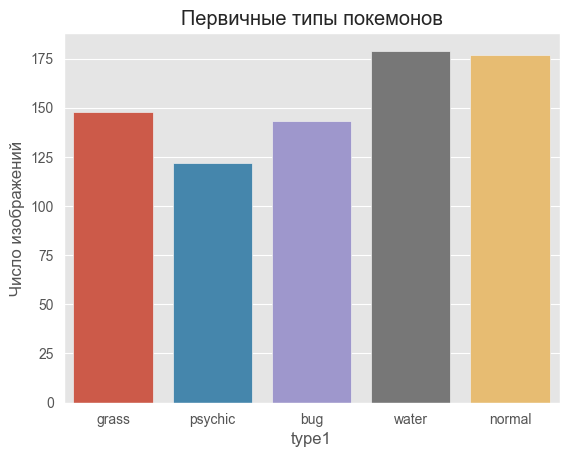

In [31]:
sns.countplot(x=data.type1, hue='type1', data=data,)
plt.title('Первичные типы покемонов')
plt.ylabel('Число изображений')

<h4>Создаем датасет на основе расположения изображений</h4>

In [14]:
path=os.path.join('images/')
img_name = sorted(os.listdir(path))
img_paths = []
for i in img_name:
    name = i.split('.')[0]
    img_paths.append({'name': name, 'path': path + i})
image_df = pd.DataFrame(img_paths)

In [15]:
# Сопостовляем новый датасет с исходным
data=data.merge(image_df,how='inner', on='name')

In [16]:
data

,name,type1,path
0,abomasnow,grass,images/abomasnow.png
1,abra,psychic,images/abra.png
2,absol,bug,images/absol.png
3,accelgor,bug,images/accelgor.png
4,aerodactyl,water,images/aerodactyl.png
...,...,...,...
764,zigzagoon,normal,images/zigzagoon.png
765,zoroark,bug,images/zoroark.png
766,zorua,grass,images/zorua.png
767,zubat,water,images/zubat.png


<h4>Аугментируем изображения датасета с помощью генератора</h4>

In [18]:
train_datagenerator = ImageDataGenerator(
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)
# Генератор из обучающего датасета
train_generator = train_datagenerator.flow_from_dataframe(
    data,
    x_col='path',
    y_col='type1',
    target_size=(120, 120),
    color_mode='rgba',
    classes=most_common,
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=1,
    subset='training')
# Генератор из тренировочного датасета
validation_generator = train_datagenerator.flow_from_dataframe(
    data ,
    x_col='path',
    y_col='type1',
    target_size=(120, 120),
    color_mode='rgba',
    classes=most_common,
    class_mode='categorical',
    batch_size=4,
    shuffle=True,
    seed=1,
    subset='validation'
)

Found 616 validated image filenames belonging to 5 classes.
Found 153 validated image filenames belonging to 5 classes.


<h4>Модель сверточной сети: <u>D + (CV + MP)^3 + DO + F + D + S</u></h4>

In [19]:
# Строим модель сверточной нейронной сети
model = ks.models.Sequential()
model.add(ks.layers.Dense(4, input_shape=(120, 120, 4)))

model.add(ks.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(2, 2))

model.add(ks.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(2, 2))

model.add(ks.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(2, 2))

model.add(ks.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(2, 2))
model.add(ks.layers.Dropout(0.2))

model.add(ks.layers.Flatten())

model.add(ks.layers.Dense(1024, activation='relu'))

model.add(ks.layers.Dense(NUM_CLASSES, activation='softmax'))

In [20]:
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 120, 120, 4)    │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 118, 118, 64)   │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 57, 57, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,664,921 (55.94 MB)

 Trainable params: 14,664,921 (55.94 MB)

 Non-trainable params: 0 (0.00 B)

<h4>Обучаем модель на 50 эпохах</h4>

In [21]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator
)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 881ms/step - accuracy: 0.2654 - loss: 2.3423 - val_accuracy: 0.2418 - val_loss: 1.6028
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 887ms/step - accuracy: 0.2184 - loss: 1.6046 - val_accuracy: 0.2353 - val_loss: 1.6073
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 792ms/step - accuracy: 0.2636 - loss: 1.6019 - val_accuracy: 0.2092 - val_loss: 1.6052
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 801ms/step - accuracy: 0.2197 - loss: 1.6030 - val_accuracy: 0.2418 - val_loss: 1.6028
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 874ms/step - accuracy: 0.2387 - loss: 1.6039 - val_accuracy: 0.2092 - val_loss: 1.6047
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 834ms/step - accuracy: 0.2340 - loss: 1.6015 - val_accuracy: 0.2288 - val_loss: 1.5981
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 734ms/step - accuracy: 0.2560 - loss: 1.6025 - val_accuracy: 0.2092 - val_loss: 1.6037
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 740ms/step - accuracy: 0.2589 - loss: 1.5989 - val_accu

<h4>Сохраняем модель и график точности</h4>

In [23]:
model.save('models/type1/best/model.h5')

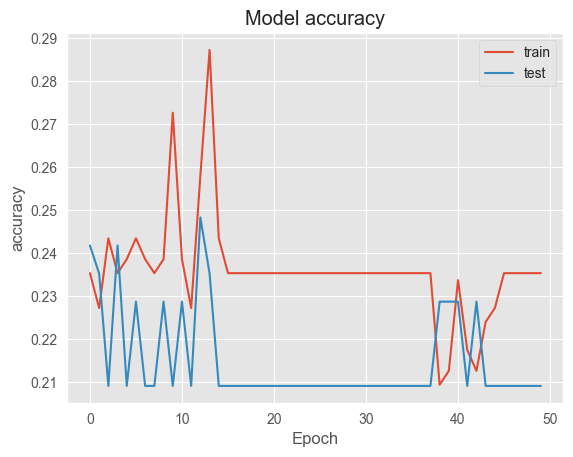

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])
plt.savefig('models/type1/best/accuracy.png')

<h4>Проверяем модель на изображении покемона</h4>

In [25]:
import matplotlib.image as mpimg
def predict(model, image_path):
    image = mpimg.imread(image_path)
    image = np.expand_dims(image, axis=0)
    return model.predict(image)

In [26]:
class_names = most_common
def predict_type1(model, img_path):
    label = img_path.split('/')[-1].split('.')[0]
    prediction = predict(model, img_path)[0]
    result = {class_names[i]: prediction[i] for i in range(len(prediction))}
    print(f'{label} тип 1: {result}')

In [28]:
predict_type1(model, 'images/aipom.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
aipom тип 1: {'water': 0.23079973, 'normal': 0.23737994, 'grass': 0.18568216, 'bug': 0.18329062, 'psychic': 0.16284755}
